#6. Ensemble Learning

이번 시간에는 Scikit-Learn (sklearn) 패키지를 사용하여 ensemble learning과 test를 진행합니다. 수업 시간에 이야기 나눈 sklearn 적용의 5단계 과정을 다시 기억해 봅시다.

- Step 1 - Separating training and testing datasets

- Steps 2 & 3 - Optimize hyperparameters via cross validation

- Step 4 - Model performance

- Step 5 - Train final model on full dataset (optional step)

RF, LogReg 모델을 구동 및 평가해보기 위해 사용했던 Iris 데이터셋을 다시 불러옵니다. 앞서 실습에서와 동일하게, MinMaxScaler를 사용하여 normalize 합니다.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = load_iris(return_X_y=True)
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.4, random_state=777)

# Data normalization
normalizer = MinMaxScaler(feature_range=(0, 1))
normalizer.fit(X_tr)
X_tr_normalized = normalizer.transform(X_tr)
X_ts_normalized = normalizer.transform(X_ts)

##6.1. Bagged Logistic Regression

먼저 bagging 기법을 사용하여 여러 logistic regression 모델을 학습하고, 예측에 활용하는 실습을 해봅니다. 

실습을 위해 필요한 라이브러리들을 import 합니다.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, log_loss)

다음 함수는 bagged logistic regression을 학습 및 테스트 합니다.

In [ ]:
def test_bagged_logreg(K, X_tr, y_tr, X_ts, y_ts):
  # Base model로 logistic regression을 생성합니다.
  base = LogisticRegression(penalty='l2', max_iter=5000)
  # Ensemble (bagged) model을 생성합니다.
  # 위에서 지정한 base model을 파라메터로 사용하며, ensemble을 구성하는 base model의 수를 K개로 지정합니다.
  # n_jobs=-1은 사용가능한 CPU를 모두 사용해서 학습을 빠르게 진행할 수 있도록 합니다.
  clf = BaggingClassifier(base, n_estimators=K, bootstrap=True, n_jobs=-1)

  # GridSearchCV를 위한 search space를 지정합니다.
  parameters = {'base_estimator__C': [10e-5, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3, 10e5]}

  # GridSearchCV를 사용하여 hyperparameter tuning과 model training을 순차적으로 진행합니다.
  gridsearch = GridSearchCV(clf, parameters, scoring='accuracy', cv=5)
  gridsearch.fit(X_tr, y_tr)
  # print(f'gridsearch.best_params_ = {gridsearch.best_params_}')

  # Get the model with best hyperparameters
  best_clf = gridsearch.best_estimator_

  # Get the best model performance from testing set
  y_pred = best_clf.predict(X_ts)
  test_acc = accuracy_score(y_ts, y_pred)
  # print(f'test_acc = {test_acc}')

  return best_clf, y_pred, test_acc


작성된 test_bagged_logreg() 함수를 사용하여, K=3 일 때 Iris 데이터셋 대한 bagged logistic regression model의 성능을 살펴봅니다.


In [ ]:
test_bagged_logreg(3, X_tr_normalized, y_tr, X_ts_normalized, y_ts)

(BaggingClassifier(base_estimator=LogisticRegression(C=100.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=5000,
                                                     multi_class='auto',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=None,
                                                     solver='lbfgs', tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False),
                   bootstrap=True, bootstrap_features=False, max_features=1.0,
                   max_samples=1.0, n_estimators=3

**Q: 출력된 test_bagged_logreg() 함수의 결과를 이해해봅시다.**

- Test 정확도는 어떻게 되나요? Logistic regression이 단독으로 사용되었을 때와 성능 차이가 어떻게 나나요?

- 출력된 결과 중 GridSearchCV가 찾은 최적의 hyperparameter들은 어떻게 되나요? 각각 의미를 설명할 수 있나요?

- 출력된 결과 중 X_ts에 대한 예측 결과를 pinpoint 할 수 있나요?

##6.2. Boosted Logistic Regression

이번엔 boosting 기법을 사용하여 여러 logistic regression 모델을 ensemble로 구성하여 학습 및 예측에 활용하는 실습을 해봅니다. 다음 함수는 boosted logistic regression을 학습 및 테스트 합니다.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

def test_boosted_logreg(K, X_tr, y_tr, X_ts, y_ts):
  # Base model로 logistic regression을 생성합니다.
  base = LogisticRegression(penalty='l2', max_iter=5000)
  # Ensemble (boosted) model을 생성합니다.
  # 위에서 지정한 base model을 파라메터로 사용하며, ensemble을 구성하는 base model의 수를 K개로 지정합니다.
  # n_jobs=-1은 사용가능한 CPU를 모두 사용해서 학습을 빠르게 진행할 수 있도록 합니다.
  clf = AdaBoostClassifier(base, n_estimators=K)

  # GridSearchCV를 위한 search space를 지정합니다.
  parameters = {'base_estimator__C': [10e-5, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3, 10e5]}

  # GridSearchCV를 사용하여 hyperparameter tuning과 model training을 순차적으로 진행합니다.
  gridsearch = GridSearchCV(clf, parameters, scoring='accuracy', cv=5)
  gridsearch.fit(X_tr_normalized, y_tr)
  # print(f'gridsearch.best_params_ = {gridsearch.best_params_}')

  # Get the model with best hyperparameters
  best_clf = gridsearch.best_estimator_

  # Get the best model performance from testing set
  y_pred = best_clf.predict(X_ts)
  test_acc = accuracy_score(y_ts, y_pred)
  # print(f'test_acc = {test_acc}')

  return best_clf, y_pred, test_acc


작성된 test_boosted_logreg() 함수를 사용하여, K=3 일 때 Iris 데이터셋 대한 boosted logistic regression model의 성능을 살펴봅니다.


In [ ]:
test_boosted_logreg(3, X_tr_normalized, y_tr, X_ts_normalized, y_ts)

(AdaBoostClassifier(algorithm='SAMME.R',
                    base_estimator=LogisticRegression(C=100.0, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                                      max_iter=5000,
                                                      multi_class='auto',
                                                      n_jobs=None, penalty='l2',
                                                      random_state=None,
                                                      solver='lbfgs', tol=0.0001,
                                                      verbose=0,
                                                      warm_start=False),
                    learning_rate=1.0, n_estimators=3, random_state=None),
 

**Q: 출력된 test_boosted_logreg() 함수의 결과를 이해해봅시다.**

- Test 정확도는 어떻게 되나요? Logistic regression이 단독으로 사용되었을 때와 성능 차이가 어떻게 나나요? Bagging 결과와 비교했을 때엔 성능 차이가 어떻게 나나요?

- 출력된 결과 중 GridSearchCV가 찾은 최적의 hyperparameter들은 어떻게 되나요? 각각 의미를 설명할 수 있나요?

- 출력된 결과 중 X_ts에 대한 예측 결과를 pinpoint 할 수 있나요?

##6.3. Benchmark

이번 절에서는 `make_circles` 모듈을 사용하여 생성된 1,000개의 데이터와 ML 입문 학습에서 많이 사용되는 `breast_cancer` 데이터셋을 사용하여 bagging과 boosting의 성능 차이를 살펴봅니다.

#### `make_circles`
먼저 다음과 같은 코드를 작성하여 circle dataset을 생성하고, logistc regression이 사용할 수 있도록 normalize 합니다.

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)


from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Generate a dataset
X, y = make_circles(n_samples=1000, factor=.3, noise=.05)
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.4, random_state=777)

# Data normalization
normalizer = MinMaxScaler(feature_range=(0, 1))
normalizer.fit(X_tr)
X_tr_normalized = normalizer.transform(X_tr)
X_ts_normalized = normalizer.transform(X_ts)


이제 다음의 코드를 실행시켜 K의 값을 1부터 30까지 변화시키며 bagging 및 boosting 시 성능 차이를 비교하는 실험을 진행합니다.

In [ ]:
test_acc_bagging = []
test_acc_boosting = []

exp_range = range(1, 31)

for n_estimators in exp_range:
  # showing progress
  if n_estimators % 5 == 0:
    print(n_estimators, end = '')
  else:
    print('.', end = '')
  
  # bagging
  _, y_pred, t = test_bagged_logreg(n_estimators, X_tr_normalized, y_tr, X_ts_normalized, y_ts)
  test_acc_bagging.append(accuracy_score(y_ts, y_pred))
  
  
  # boosting
  _, y_pred, t = test_boosted_logreg(n_estimators, X_tr_normalized, y_tr, X_ts_normalized, y_ts)
  test_acc_boosting.append(accuracy_score(y_ts, y_pred))

print(test_acc_bagging)
print(test_acc_boosting)


....5....10....15....20....25....30[0.3175, 0.4925, 0.6475, 0.62, 0.52, 0.505, 0.4725, 0.665, 0.325, 0.5975, 0.5475, 0.6325, 0.41, 0.6375, 0.545, 0.6, 0.6375, 0.4925, 0.5125, 0.4825, 0.655, 0.6125, 0.6625, 0.5525, 0.435, 0.62, 0.4925, 0.6275, 0.4925, 0.4925]
[0.6425, 0.4925, 0.5375, 0.59, 0.625, 0.6375, 0.6525, 0.6625, 0.665, 0.665, 0.665, 0.6675, 0.6675, 0.675, 0.4925, 0.4925, 0.4925, 0.4925, 0.4925, 0.4925, 0.4925, 0.4925, 0.4925, 0.4925, 0.495, 0.5125, 0.52, 0.535, 0.5475, 0.5575]


실험이 완료되면, `test_acc_bagging`와 `test_acc_boosting`에 결과가 담깁니다. 다음 코드를 실행시켜 line plot을 그리고, 결과를 분석해 봅니다.

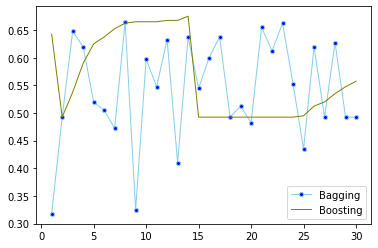

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# multiple line plot
plt.plot(exp_range, test_acc_bagging, marker='o', markerfacecolor='blue', markersize=4,
         color='skyblue', linewidth=1)
plt.plot(exp_range, test_acc_boosting, marker='', color='olive', linewidth=1)
plt.legend(['Bagging','Boosting'])


**Q: 실험 결과를 통해 관찰된 bagging과 boosting의 성능상 차이를 설명할 수 있나요?**

- K=1일 때, 두 방법 간 성능 차이가 있나요? 결과의 원인을 설명할 수 있나요? 
K=1일 때, bagging과 boosting 중, 어떤 결과가 single logistic regression(즉, base model을 ensemble 없이 단독으로 사용한 경우)의 결과에 해당 하나요?

- Single logistic regression을 사용했을 때에 비해, bagging 결과에서 향상된 성능을 관찰 할 수 있었나요?

- Single logistic regression을 사용했을 때에 비해, boosting 결과에서 향상된 성능을 관찰 할 수 있었나요?

- Bagging과 boosting 중 어떤 방법을 더 선호하게 되나요? 이유는 무엇인가요?

#### `breast_cancer`
이번엔 실제 데이터셋을 사용하여 bagging과 boosting 시 성능 차이를 살펴보려합니다.

먼저 다음의 코드를 작성하여 `breast_cancer` 데이터셋을 불러오고, logistc regression이 사용할 수 있도록 normalize 합니다.

해당 데이터셋은 Sklearn에 포함되어 있어, 간단한 함수 호출만으로 불러들일 수 있습니다 (하단 코드 12행 `load_breast_cancer`()). 총 30개의 features (input)와 암 여부에 해당하는 1개의 y label (output) 값을 가지고 있습니다.

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)


from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = load_breast_cancer(return_X_y=True)
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.4, random_state=777)

# Data normalization
normalizer = MinMaxScaler(feature_range=(0, 1))
normalizer.fit(X_tr)
X_tr_normalized = normalizer.transform(X_tr)
X_ts_normalized = normalizer.transform(X_ts)


이제 위에서 사용했던 코드를 다시 한 번 실행시켜서, `breast_cancer` 데이터셋에 대한 동일한 실험을 진행합니다.

In [ ]:
test_acc_bagging = []
test_acc_boosting = []

exp_range = range(1, 31)

for n_estimators in exp_range:
  # showing progress
  if n_estimators % 5 == 0:
    print(n_estimators, end = '')
  else:
    print('.', end = '')
  
  # bagging
  _, y_pred, t = test_bagged_logreg(n_estimators, X_tr_normalized, y_tr, X_ts_normalized, y_ts)
  test_acc_bagging.append(accuracy_score(y_ts, y_pred))
  
  # boosting
  _, y_pred, t = test_boosted_logreg(n_estimators, X_tr_normalized, y_tr, X_ts_normalized, y_ts)
  test_acc_boosting.append(accuracy_score(y_ts, y_pred))

print(test_acc_bagging)
print(test_acc_boosting)


....5....10....15....20....25....30[0.9692982456140351, 0.9736842105263158, 0.9736842105263158, 0.9736842105263158, 0.9736842105263158, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965, 0.9736842105263158, 0.9780701754385965, 0.9780701754385965, 0.9736842105263158, 0.9824561403508771, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965, 0.9736842105263158, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965, 0.9780701754385965]
[0.9692982456140351, 0.9605263157894737, 0.9780701754385965, 0.9692982456140351, 0.9649122807017544, 0.956140350877193, 0.956140350877193, 0.956140350877193, 0.956140350877193, 0.956140350877193, 0.9692982456140351, 0.9736842105263158, 0.9736842105263158, 0.9736842105263158, 0.9736842105263158, 0.9736842105263158, 0.9736842105263158, 0.9692982456140351, 0.969298

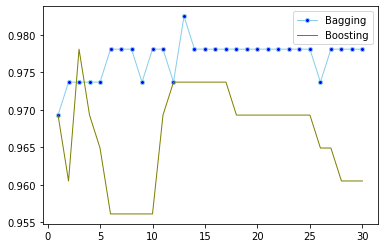

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# multiple line plot
plt.plot(exp_range, test_acc_bagging, marker='o', markerfacecolor='blue', markersize=4, 
         color='skyblue', linewidth=1)
plt.plot(exp_range, test_acc_boosting, marker='', color='olive', linewidth=1)
plt.legend(['Bagging','Boosting'])


**Q: 실험 결과를 통해 관찰된 bagging과 boosting의 성능상 차이를 설명할 수 있나요?**

- Single logistic regression을 사용했을 때(즉, base model을 ensemble 없이 단독으로 사용했을 때)에 비해, bagging 결과에서 향상된 성능을 관찰 할 수 있었나요?

- Single logistic regression을 사용했을 때에 비해, boosting 결과에서 향상된 성능을 관찰 할 수 있었나요?

- Bagging과 boosting 중 어떤 방법을 더 선호하게 되나요? 이유는 무엇인가요?


## 과제

먼저 다음의 코드를 사용하여 MNIST 데이터셋(Day 1에 사용했던 0/1로 표현된 숫자 이미지 데이터)을 불러옵니다. 입력 파라메터의 값이 'train', 'test' 중 어떤 값이 주어지는지에 따라 각각 training dataset 혹은 test dataset이 리턴 됩니다.

1. Lab 3-1에서 실습해본 logistic regression과 decision tree 학습 알고리듬을 적용해보고, 산출된 예측 모델을 사용하여 train dataset과 test dataset에 대한 예측 정확도를 각각 측정, 보고합니다.

 * 정확도(accuracy)는 다음과 같이 정의됩니다: (맞은 예측 수) / (전체 예측 수)

2. Lab 3-1과 3-2에서 실습해본 ensemble 기법들을 적용 및 평가해 봅니다. 즉, Random forest 방법과 bagging 및 boosting (logistic regression 모델에 적용) 방법을 사용하여 train dataset과 test dataset에 대한 예측 정확도를 각각 보고합니다.

제출: 1, 2의 내용을 담은 스프레드시트, 작성된 Python 코드 (.py나 .ipynb파일을 제출)

In [2]:
# 과제 코드1: 데이터셋을 불러오는 코드. 
#          두 함수 img2vector()와 load_mnist()로 구성
import numpy as np
import os

IMG_WIDTH = 32
IMG_HEIGHT = 32

def img2vector(filename):
  vect = np.zeros((1, 1024))
  file = open(filename)
  for i in range(IMG_HEIGHT):
    line = file.readline()
    for j in range(IMG_WIDTH):
      vect[0, 32*i+j] = int(line[j])
  return vect

def load_mnist(split):
  if split == "train":
    dirname_str = 'drive/My Drive/datasets/MLPracticum/digits/trainingDigits'
  elif split == "test":
    dirname_str = 'drive/My Drive/datasets/MLPracticum/digits/testDigits'
  
  filelist = os.listdir(dirname_str)
  N = len(filelist)
  X = np.zeros((N, 1024))
  y = []
  
  # training data
  for i in range(N):
    if i%100 == 0:
      print('(load_mnist) Busy...', i, '/', N)
    
    filename_str = filelist[i].split('.')[0]
    label = int(filename_str.split('_')[0])
    y.append(label)
    X[i,:] = img2vector('%s/%s' % (dirname_str, filelist[i]))
    
  return X, y

In [3]:
# 과제 코드2: 필요한 경우 구글 드라이브와 연결합니다.
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# 과제 코드3: 위에서 작성한 코드를 사용하여 MNIST 데이터를 불러옵니다.
# Example usages 
# (heads up: loading a large number of small-sized files from Google Drive may take a while)
X_tr, y_tr = load_mnist('train')
X_ts, y_ts = load_mnist('test')

(load_mnist) Busy... 0 / 1934
(load_mnist) Busy... 100 / 1934
(load_mnist) Busy... 200 / 1934
(load_mnist) Busy... 300 / 1934
(load_mnist) Busy... 400 / 1934
(load_mnist) Busy... 500 / 1934
(load_mnist) Busy... 600 / 1934
(load_mnist) Busy... 700 / 1934
(load_mnist) Busy... 800 / 1934
(load_mnist) Busy... 900 / 1934
(load_mnist) Busy... 1000 / 1934
(load_mnist) Busy... 1100 / 1934
(load_mnist) Busy... 1200 / 1934
(load_mnist) Busy... 1300 / 1934
(load_mnist) Busy... 1400 / 1934
(load_mnist) Busy... 1500 / 1934
(load_mnist) Busy... 1600 / 1934
(load_mnist) Busy... 1700 / 1934
(load_mnist) Busy... 1800 / 1934
(load_mnist) Busy... 1900 / 1934
(load_mnist) Busy... 0 / 946
(load_mnist) Busy... 100 / 946
(load_mnist) Busy... 200 / 946
(load_mnist) Busy... 300 / 946
(load_mnist) Busy... 400 / 946
(load_mnist) Busy... 500 / 946
(load_mnist) Busy... 600 / 946
(load_mnist) Busy... 700 / 946
(load_mnist) Busy... 800 / 946
(load_mnist) Busy... 900 / 946


In [5]:
# 과제 코드4: 예시 코드로 불러온 MNIST 데이터에 Logistic Regression 모델을 적용하는 과정을 보여줍니다.
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, log_loss)

# Step 2: Use GridSearchCV to find optimal hyperparameter values
clf = LogisticRegression(max_iter=5000)
parameters = {'penalty': ['l2'],
              'C': [10e-5, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3, 10e5]}
gridsearch = GridSearchCV(clf, parameters, scoring='accuracy', cv=5)
gridsearch.fit(X_tr, y_tr)
print(f'gridsearch.best_params_ = {gridsearch.best_params_}')

# Step 3: Get model with best hyperparameters
best_clf = gridsearch.best_estimator_

# Step 4: Get best model performances
# (i) on training data
y_pred = best_clf.predict(X_tr)
train_acc = accuracy_score(y_tr, y_pred)
print(f'train_acc = {train_acc}')

# (ii) on test data
y_pred = best_clf.predict(X_ts)
test_acc = accuracy_score(y_ts, y_pred)
print(f'test_acc = {test_acc}')


gridsearch.best_params_ = {'C': 10000.0, 'penalty': 'l2'}
train_acc = 1.0
test_acc = 0.9682875264270613


In [6]:
print(y_pred)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0
 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0
 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 2 8 1 1 1 1 1 3 2 2 8 2 1 2 2 1 1 2
 2 2 2 2 2 1 2 2 1 1 1 2 2 2 2 2 1 2 2 1 1 1 2 1 2 2 1 2 2 2 2 1 2 2 1 2 2
 8 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 1 2 1 1 1 1 7 2 8 1 2 2 2 1 2 1 2 1 2 2
 1 2 2 1 1 8 1 1 1 2 2 2 2 2 1 2 2 2 2 2 2 1 2 1 1 1 2 1 2 1 1 2 1 1 1 1 2
 2 1 2 2 1 2 2 1 1 2 9 9 9 4 3 3 4 2 3 3 5 3 3 4 4 3 4 4 3 3 3 3 2 3 3 3 3
 4 3 3 3 3 3 4 4 3 4 4 4 4 3 3 3 3 4 4 4 3 3 4 3 3 4 3 3 4 4 4 3 3 3 3 4 3
 9 4 4 3 4 3 3 3 3 3 3 3 4 3 3 2 4 3 3 3 4 3 3 4 3 2 9 3 3 3 3 3 3 3 2 3 4
 4 3 3 3 4 3 3 3 8 3 3 3 4 4 3 3 3 4 3 4 4 4 3 2 4 3 3 3 4 4 4 3 4 3 4 3 4
 4 5 5 5 5 5 4 4 5 5 4 4 4 5 5 4 5 5 4 5 5 4 5 5 4 5 5 5 4 5 5 5 5 4 5 5 5
 8 4 4 4 5 4 4 4 4 5 4 5 4 4 5 4 4 4 4 5 4 4 4 5 4 5 4 5 4 4 4 5 5 5 6 4 4
 5 5 4 4 5 6 5 4 4 4 4 4 

In [20]:
print(best_clf.__dir__())

['penalty', 'dual', 'tol', 'C', 'fit_intercept', 'intercept_scaling', 'class_weight', 'random_state', 'solver', 'max_iter', 'multi_class', 'verbose', 'warm_start', 'n_jobs', 'l1_ratio', 'classes_', 'coef_', 'intercept_', 'n_iter_', '__module__', '__doc__', '__init__', 'fit', 'predict_proba', 'predict_log_proba', '_get_param_names', 'get_params', 'set_params', '__repr__', '__getstate__', '__setstate__', '_more_tags', '_get_tags', '__dict__', '__weakref__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__', 'decision_function', 'predict', '_predict_proba_lr', '_estimator_type', 'score', 'densify', 'sparsify']


In [19]:
import pprint

pprint.pprint(best_clf.classes_)
pprint.pprint(best_clf.coef_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
array([[ 0.        ,  0.        ,  0.        , ..., -0.05348501,
        -0.00358725, -0.00329095],
       [ 0.        ,  0.        ,  0.        , ...,  0.25773443,
         0.10717596,  0.07539906],
       [ 0.        ,  0.        ,  0.        , ...,  0.11783405,
         0.07239793,  0.08074613],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.0027839 ,
        -0.00086627, -0.00058356],
       [ 0.        ,  0.        ,  0.        , ..., -0.01083801,
        -0.00191952, -0.00124718],
       [ 0.        ,  0.        ,  0.        , ..., -0.19627877,
        -0.13679856, -0.13640324]])
